## 1. Treinando a Floresta
Configuração e Carregamento (Igual ao anterior, mas importamos o RandomForestRegressor)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Configuração visual
sns.set_theme(style="whitegrid")

# Caminhos
PROCESSED_DIR = '../data/processed'
arquivo_entrada = f'{PROCESSED_DIR}/base_modelagem.csv'

print("📂 Carregando base...")
df = pd.read_csv(arquivo_entrada, sep=';', parse_dates=['DT_COMPTC'])
df.sort_values(by='DT_COMPTC', inplace=True)
df.dropna(inplace=True)

print(f"✅ Dados prontos: {df.shape[0]} linhas.")

📂 Carregando base...
✅ Dados prontos: 4058 linhas.


Split OOT (Out of Time)

In [2]:
# Features e Target
features = [
    'RET_ACC_21D', 'RET_ACC_63D', 'RET_ACC_126D',
    'VOL_21D', 'VOL_63D', 'VOL_126D',
    'PL_LAG1'
]
target = 'TARGET_FLOW_21D'

# Data de corte (Vamos manter 3 meses para ser robusto)
data_corte = df['DT_COMPTC'].max() - pd.Timedelta(days=90)

X_train = df[df['DT_COMPTC'] < data_corte][features]
y_train = df[df['DT_COMPTC'] < data_corte][target]

X_test = df[df['DT_COMPTC'] >= data_corte][features]
y_test = df[df['DT_COMPTC'] >= data_corte][target]

print(f"📚 Treino: {X_train.shape[0]} amostras")
print(f"📝 Teste (OOT): {X_test.shape[0]} amostras")

📚 Treino: 3343 amostras
📝 Teste (OOT): 715 amostras


O Modelo Avançado Aqui está a diferença. Vamos usar 100 árvores de decisão (n_estimators=100) para votar no resultado.

🌲 Treinando Random Forest (pode demorar um pouco)...
------------------------------
📊 RESULTADOS (RANDOM FOREST):
RMSE (Erro): 0.0652
R² (Score):  0.3463
------------------------------


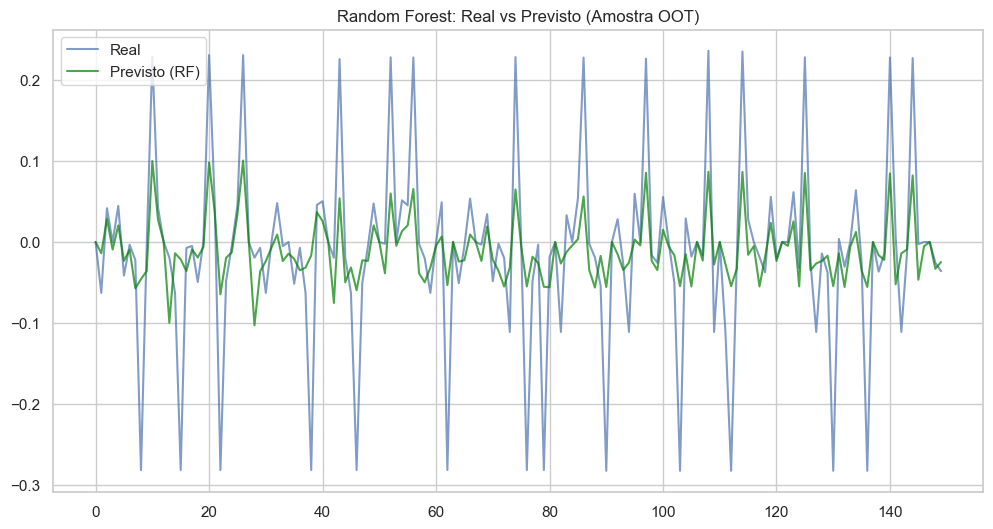

In [3]:
print("🌲 Treinando Random Forest (pode demorar um pouco)...")

# Configurando o modelo
# n_estimators=100: Cria 100 árvores
# max_depth=10: Limita o tamanho da árvore para não decorar os dados (evita overfitting)
# random_state=42: Garante que o resultado seja sempre igual (reprodutibilidade)
mdl = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

mdl.fit(X_train, y_train)

# Previsões
y_pred = mdl.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("-" * 30)
print(f"📊 RESULTADOS (RANDOM FOREST):")
print(f"RMSE (Erro): {rmse:.4f}")
print(f"R² (Score):  {r2:.4f}")
print("-" * 30)

# Gráfico de Previsão (Zoom em 100 dias)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:150], label='Real', alpha=0.7)
plt.plot(y_pred[:150], label='Previsto (RF)', color='green', alpha=0.7)
plt.title("Random Forest: Real vs Previsto (Amostra OOT)")
plt.legend()
plt.show()

## 2. O Que Realmente Importa? (Feature Importance Não-Linear)
A Random Forest tem um jeito diferente de calcular importância. Ela vê quais variáveis "quebram" melhor os nós das árvores.

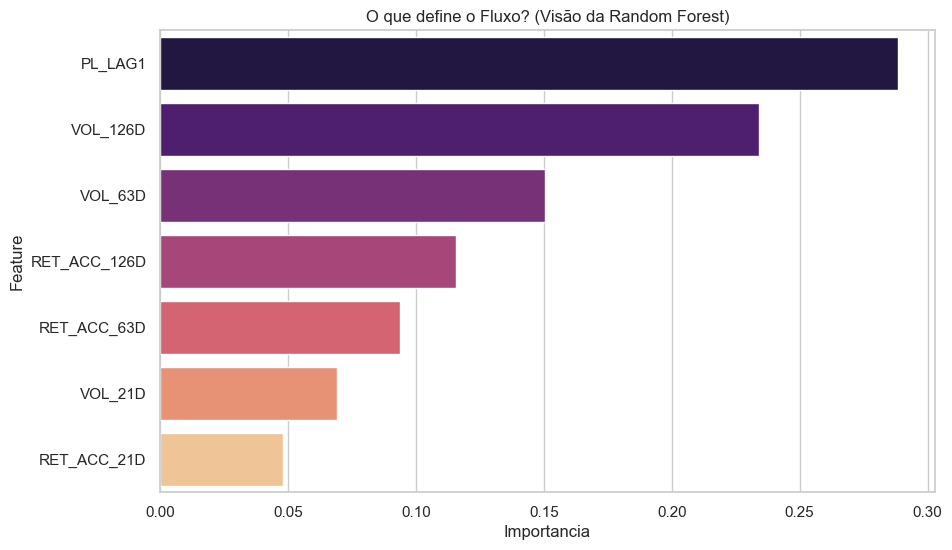

        Feature  Importancia
6       PL_LAG1     0.288408
5      VOL_126D     0.234103
4       VOL_63D     0.150322
2  RET_ACC_126D     0.115893
1   RET_ACC_63D     0.093965
3       VOL_21D     0.069365
0   RET_ACC_21D     0.047944


In [4]:
# Feature Importance da Floresta
importancia = pd.DataFrame({
    'Feature': features,
    'Importancia': mdl.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importancia, x='Importancia', y='Feature', hue='Feature', palette='magma')
plt.title("O que define o Fluxo? (Visão da Random Forest)")
plt.show()

print(importancia)